## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot
water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [13]:
import pandas as pd

from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from examples.example_utils import init_input_data, calculate_regression_metric
from golem.core.tuning.sequential import SequentialTuner
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [14]:
model_dict = {
    'regression_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                       params={'window_size': 5}).add_node('ridge'),
    'regression_pca_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                           params={'window_size': 5}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).add_node('ridge'),
    'regression_pca_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_pca_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge')
}

dataset_name = 'ElectricityPredictor'
data_path = PROJECT_PATH + '/examples/data'
tuning_params = {'task': 'regression',
                 'metric': RegressionMetricsEnum.RMSE,
                 'tuning_timeout':10,
                 'tuning_iterations':30}

In [15]:
from functools import partial


def evaluate_industrial_model(train_data, test_data, task:str = 'regression'):
    metric_dict = {}
    input_data = init_input_data(train_data[0], train_data[1], task=task)
    val_data = init_input_data(test_data[0], test_data[1], task=task)
    with IndustrialModels():
        for model in model_dict.keys():
            print(f'Current_model - {model}')
            pipeline = model_dict[model].build()
            pipeline.fit(input_data)
            features = pipeline.predict(val_data).predict
            metric = calculate_regression_metric(test_target=test_data[1], labels=features)
            metric_dict.update({model: metric})
    return metric_dict

def tuning_industrial_pipelines(pipeline, tuning_params, train_data):
    input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
    pipeline_tuner = TunerBuilder(input_data.task) \
        .with_tuner(partial(SequentialTuner, inverse_node_order=True)) \
        .with_metric(tuning_params['metric']) \
        .with_timeout(tuning_params['tuning_timeout']) \
        .with_iterations(tuning_params['tuning_iterations']) \
        .build(input_data)

    pipeline = pipeline_tuner.tune(pipeline)
    return pipeline

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [16]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-09 15:42:50,001 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/ElectricityPredictor


In [17]:
input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
val_data = init_input_data(test_data[0], test_data[1], task=tuning_params['task'])

Lets check our data.

In [18]:
input_data.features.shape

(567, 4, 168)

Lets visualise our predictors.

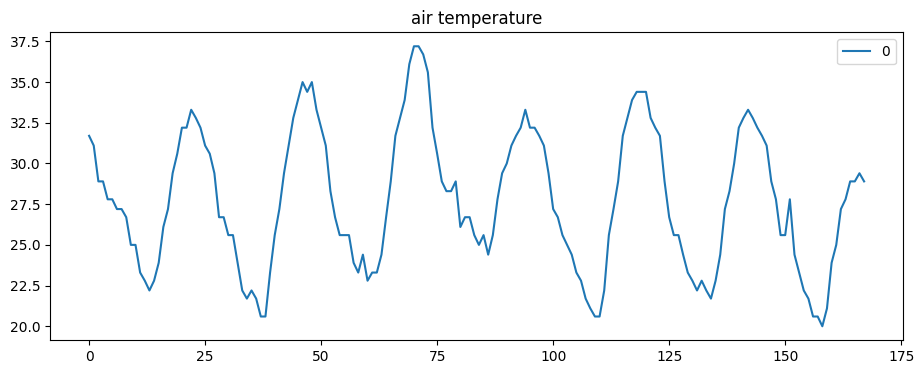

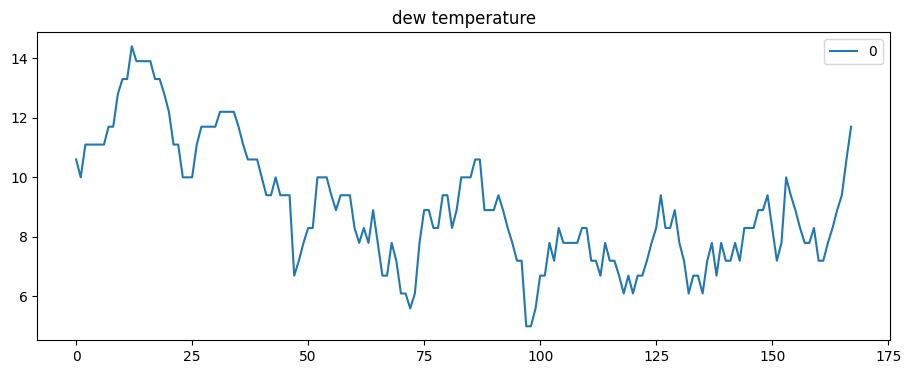

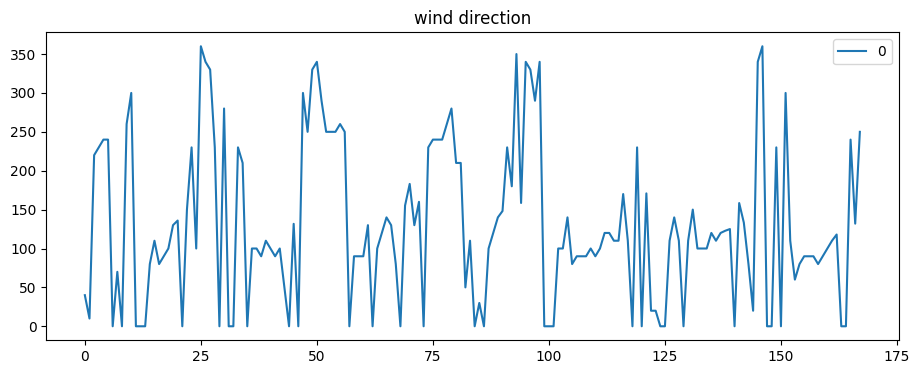

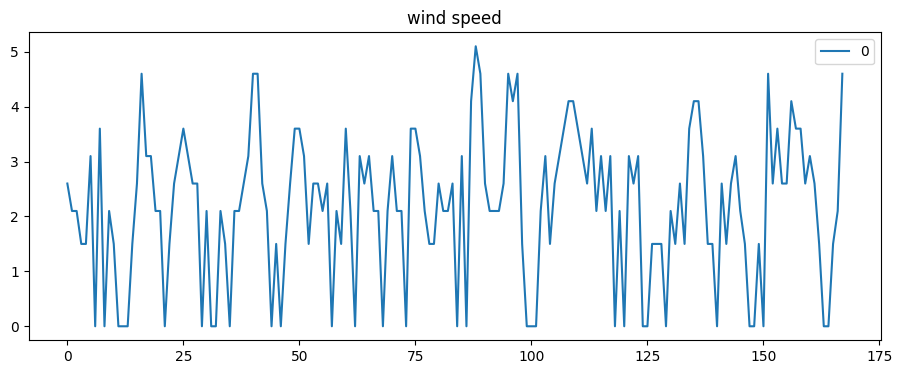

In [19]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='air temperature')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='dew temperature')
pd.DataFrame(input_data.features[1, 2, :]).plot(title='wind direction')
pd.DataFrame(input_data.features[1, 3, :]).plot(title='wind speed')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [20]:
metric_dict = evaluate_industrial_model(train_data,test_data)

Current_model - regression_with_statistical_features
Current_model - regression_pca_with_statistical_features
Current_model - regression_with_reccurence_features
Current_model - regression_pca_with_reccurence_features
Current_model - regression_with_topological_features
Current_model - regression_pca_with_topological_features


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [21]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline.sort_values(by='root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_pca_with_reccurence_features,0.080487,242844.478589,492.792531,244.728677,120.852159,0.085936,2167.000715,-0.268740
regression_with_reccurence_features,0.038808,253851.946498,503.837222,258.780680,126.047284,0.043402,2183.389781,-0.341590
regression_with_topological_features,0.010349,261368.003356,511.241629,243.908111,126.156833,0.013599,2345.116435,-0.264486
regression_pca_with_topological_features,0.010349,261368.003356,511.241629,243.908111,126.156833,0.013599,2345.116435,-0.264486
regression_pca_with_statistical_features,-0.002798,264840.107063,514.626182,261.164925,133.701291,-0.001518,2337.330582,-0.353950
regression_with_statistical_features,-1.644464,698406.082747,835.706936,604.766705,424.789912,-1.606454,2413.925700,-2.135276


In [10]:
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Could it be done better? Tuning approach

In [22]:
metric_dict = {}

In [23]:
with IndustrialModels():
    for model in model_dict.keys():
        print(f'Current_model - {model}')
        pipeline = model_dict[model].build()
        tuned_pipeline = tuning_industrial_pipelines(pipeline,tuning_params,train_data)
        tuned_pipeline.fit(input_data)
        features = tuned_pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str({node:node.parameters for node in tuned_pipeline.graph_description['nodes']})
        metric_dict.update({model: metric})

Current_model - regression_with_statistical_features
2023-10-09 15:44:53,617 - DataSourceSplitter - Stratificated splitting of data is disabled.
2023-10-09 15:44:53,618 - DataSourceSplitter - Hold out validation is applied.
2023-10-09 15:44:53,620 - SequentialTuner - Hyperparameters optimization start: estimation of metric for initial graph
2023-10-09 15:45:08,468 - SequentialTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 5} 
Initial metric: [753.794]
  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]2023-10-09 15:45:08,473 - build_posterior_wrapper took 0.000997 seconds
2023-10-09 15:45:08,473 - TPE using 0 trials
  7%|▋         | 1/15 [00:11<02:40, 11.49s/trial, best loss: 753.9496624585285]2023-10-09 15:45:19,966 - build_posterior_wrapper took 0.000975 seconds
2023-10-09 15:45:19,967 - TPE using 1/1 trials with best loss 753.949662
 13%|█▎        | 2/15 [00:23<02:34, 11.92s/trial, best loss: 

In [24]:
df_tuned = pd.concat([x for x in metric_dict.values()],axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
regression_with_reccurence_features,0.085962,241398.503003,491.323216,269.058427,144.576028,0.087197,2108.264973,-0.394872,"{ridge: {'alpha': 2.671746508377493}, recurren..."
regression_pca_with_reccurence_features,0.080487,242844.478589,492.792531,244.728677,120.852159,0.085936,2167.000715,-0.26874,"{ridge: {}, pca: {'svd_solver': 'full', 'n_com..."
regression_with_topological_features,0.060005,248253.725979,498.250666,240.835807,116.727277,0.062829,2076.191042,-0.248559,"{ridge: {'alpha': 8.518749615011743}, pca: {'s..."
regression_pca_with_topological_features,0.059872,248288.864243,498.285926,244.145529,121.311948,0.061968,2139.069571,-0.265717,"{ridge: {'alpha': 0.9147556926771431}, pca: {'..."
regression_pca_with_statistical_features,-0.002798,264840.107063,514.626182,261.164925,133.701291,-0.001518,2337.330582,-0.35395,"{ridge: {}, pca: {'svd_solver': 'full', 'n_com..."
regression_with_statistical_features,-1.483146,655801.748375,809.815873,560.532275,360.750976,-1.434199,2405.811682,-1.905952,"{ridge: {'alpha': 9.05286146490461}, quantile_..."


In [25]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

"{ridge: {'alpha': 2.671746508377493}, recurrence_extractor: {'window_size': 25, 'stride': 2}}"

In [26]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [27]:
metric_dict = {}
runs = 5
for run in range(runs):
    with IndustrialModels():
        auto_ml = PipelineBuilder().add_node('recurrence_extractor',
                                              params={'window_size': 25, 'stride': 2}).add_node('fedot_regr',
                                                                             params={'timeout': 10,'logging_level':30}).build()
        auto_ml.fit(input_data)
        features = auto_ml.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str({node:node.parameters for node in auto_ml.graph_description['nodes']})
        metric_dict.update({f'run_number - {run}':metric})

2023-10-09 16:24:50,258 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.8 MiB, max: 5.6 MiB
2023-10-09 16:24:50,259 - ApiComposer - Initial pipeline was fitted in 1.9 sec.
2023-10-09 16:24:50,260 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-10-09 16:24:50,267 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate models: ['rfr', 'ridge', 'scaling', 'normalization', 'pca', 'catboostreg', 'xgbreg', 'svr', 'dtreg', 'treg', 'knnreg', 'fast_ica', 'kernel_pca', 'isolation_forest_reg', 'rfe_lin_reg', 'rfe_non_lin_reg'].
2023-10-09 16:24:50,270 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 16:24:57,550 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 16:25:19,284 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 16:25:27,212 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2023-10-09 16:25:39,878 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2023-10-09 16:25:41,586 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 16:25:48,811 - MultiprocessingDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2023-10-09 16:25:50,694 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 16:25:51,165 - MultiprocessingDispatcher - 3 individuals out of 3 in previous po

Generations:   0%|          | 1/10000 [09:56<?, ?gen/s]

2023-10-09 16:34:46,501 - ApiComposer - Model generation finished


2023-10-09 16:34:49,065 - FEDOT logger - Final pipeline was fitted
2023-10-09 16:34:49,066 - FEDOT logger - Final pipeline: {'depth': 7, 'length': 7, 'nodes': [treg, svr, scaling, isolation_forest_reg, resample, fast_ica, pca]}
treg - {'max_features': 0.9692738372005898, 'min_samples_split': 18, 'min_samples_leaf': 11, 'bootstrap': False}
svr - {}
scaling - {}
isolation_forest_reg - {}
resample - {'balance': 'expand_minority', 'replace': False, 'balance_ratio': 1}
fast_ica - {'whiten': 'unit-variance'}
pca - {'svd_solver': 'full', 'n_components': 0.7}
2023-10-09 16:34:49,068 - MemoryAnalytics - Memory consumption for finish in main session: current 4.7 MiB, max: 10.8 MiB
2023-10-09 16:34:53,903 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.7 MiB, max: 5.4 MiB
2023-10-09 16:34:53,904 - ApiComposer - Initial pipeline was fitted in 1.6 sec.
2023-10-09 16:34:53,905 - AssumptionsHandler - Preset was changed to best_quality due to fi

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 16:34:56,120 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 16:35:21,001 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 16:35:50,180 - MultiprocessingDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.
2023-10-09 16:35:50,915 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 16:35:53,723 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2023-10-09 16:35:54,380 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 16:36:00,045 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2023-10-09 16:36:03,509 - MultiprocessingDispatcher - 8 individuals out of 8 in previous 

Generations:   0%|          | 1/10000 [09:47<?, ?gen/s]


2023-10-09 16:44:41,148 - ApiComposer - Model generation finished
2023-10-09 16:44:42,161 - FEDOT logger - Final pipeline was fitted
2023-10-09 16:44:42,163 - FEDOT logger - Final pipeline: {'depth': 5, 'length': 5, 'nodes': [ridge, pca, isolation_forest_reg, normalization, resample]}
ridge - {'alpha': 6.62055874397956}
pca - {'svd_solver': 'full', 'n_components': 0.2187848583572159}
isolation_forest_reg - {}
normalization - {}
resample - {'balance': 'expand_minority', 'replace': False, 'balance_ratio': 1}
2023-10-09 16:44:42,163 - MemoryAnalytics - Memory consumption for finish in main session: current 4.1 MiB, max: 10.0 MiB
2023-10-09 16:44:46,773 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.7 MiB, max: 5.4 MiB
2023-10-09 16:44:46,774 - ApiComposer - Initial pipeline was fitted in 1.6 sec.
2023-10-09 16:44:46,774 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-10-0

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 16:44:48,477 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 16:45:21,106 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 16:45:56,287 - MultiprocessingDispatcher - 15 individuals out of 15 in previous population were evaluated successfully.
2023-10-09 16:46:01,450 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2023-10-09 16:46:42,335 - MultiprocessingDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.
2023-10-09 16:46:44,233 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 16:46:51,971 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 16:46:56,211 - MultiprocessingDispatcher - 14 individuals out of 14 in previou

Generations:   0%|          | 1/10000 [09:47<?, ?gen/s]


2023-10-09 16:54:34,107 - ApiComposer - Model generation finished
2023-10-09 16:54:34,294 - FEDOT logger - Final pipeline was fitted
2023-10-09 16:54:34,296 - FEDOT logger - Final pipeline: {'depth': 6, 'length': 6, 'nodes': [ridge, normalization, fast_ica, normalization, pca, resample]}
ridge - {'alpha': 6.520115566528057}
normalization - {}
fast_ica - {'whiten': 'unit-variance', 'n_components': 6, 'fun': 'cube'}
normalization - {}
pca - {'svd_solver': 'full', 'n_components': 0.7}
resample - {'balance': 'expand_minority', 'replace': False, 'balance_ratio': 1}
2023-10-09 16:54:34,298 - MemoryAnalytics - Memory consumption for finish in main session: current 3.6 MiB, max: 12.1 MiB
2023-10-09 16:54:38,977 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.7 MiB, max: 5.4 MiB
2023-10-09 16:54:38,978 - ApiComposer - Initial pipeline was fitted in 1.6 sec.
2023-10-09 16:54:38,980 - AssumptionsHandler - Preset was changed to best_quality 

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 16:54:40,873 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 16:55:11,070 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 16:55:33,741 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2023-10-09 16:55:36,538 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2023-10-09 16:55:37,357 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 16:55:50,449 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 16:55:53,690 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2023-10-09 16:56:03,136 - MultiprocessingDispatcher - 25 individuals out of 25 in previou

Generations:   0%|          | 1/10000 [09:54<?, ?gen/s]

2023-10-09 17:04:34,142 - ApiComposer - Model generation finished


2023-10-09 17:04:35,088 - FEDOT logger - Final pipeline was fitted
2023-10-09 17:04:35,090 - FEDOT logger - Final pipeline: {'depth': 6, 'length': 8, 'nodes': [ridge, pca, isolation_forest_reg, resample, pca, normalization, normalization, scaling]}
ridge - {'alpha': 4.4996825838125245}
pca - {'svd_solver': 'full', 'n_components': 0.7}
isolation_forest_reg - {'max_samples': 0.8784623773028627, 'max_features': 0.4819803289315286, 'bootstrap': False}
resample - {'balance': 'expand_minority', 'replace': False, 'balance_ratio': 0.9345135904539794}
pca - {'svd_solver': 'full', 'n_components': 0.7}
normalization - {}
normalization - {}
scaling - {}
2023-10-09 17:04:35,091 - MemoryAnalytics - Memory consumption for finish in main session: current 4.6 MiB, max: 12.1 MiB
2023-10-09 17:04:39,766 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.7 MiB, max: 5.4 MiB
2023-10-09 17:04:39,768 - ApiComposer - Initial pipeline was fitted in 1.5 sec.

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 17:04:41,352 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 17:05:06,168 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 17:05:38,540 - MultiprocessingDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.
2023-10-09 17:05:39,693 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 17:06:21,302 - MultiprocessingDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.
2023-10-09 17:06:23,383 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 17:06:28,678 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 17:06:38,770 - MultiprocessingDispatcher - 14 individuals out of 14 in previou

Generations:   0%|          | 1/10000 [09:52<?, ?gen/s]


2023-10-09 17:14:32,970 - ApiComposer - Model generation finished
2023-10-09 17:14:33,875 - FEDOT logger - Final pipeline was fitted
2023-10-09 17:14:33,877 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, isolation_forest_reg, normalization]}
ridge - {'alpha': 2.8230574623414832}
isolation_forest_reg - {'max_samples': 0.8564856493691568, 'max_features': 0.08359953031874037, 'bootstrap': False}
normalization - {}
2023-10-09 17:14:33,879 - MemoryAnalytics - Memory consumption for finish in main session: current 3.1 MiB, max: 7.9 MiB


In [28]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
run_number - 3,0.112933,234275.486586,484.02013,248.559733,125.777939,0.116121,2155.903861,-0.288602,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 4,0.11024,234986.646191,484.754212,242.573667,113.849569,0.116248,2127.662682,-0.257568,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 1,0.102146,237124.182285,486.953984,240.224593,106.795772,0.108916,2140.707903,-0.24539,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 2,0.100784,237483.895586,487.323194,246.959405,115.911299,0.1046,2086.129884,-0.280305,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 0,0.094814,239060.56708,488.938204,234.62664,108.245939,0.09879,2199.298936,-0.216369,"{fedot_regr: {'timeout': 10, 'logging_level': ..."


## Compare with State of Art (SOTA) models

In [34]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')

In [35]:
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)
df['Fedot_Industrial_baseline'] = best_baseline
df['Fedot_Industrial_tuned'] = best_tuned
df['Fedot_Industrial_AutoML'] = 0
df['Fedot_Industrial_AutoML'].iloc[0] = df_automl['root_mean_squared_error:'].min()
df['Fedot_Industrial_AutoML'].iloc[1] = df_automl['root_mean_squared_error:'].max()
df['Fedot_Industrial_AutoML'].iloc[2] = df_automl['root_mean_squared_error:'].mean()
df = df.T

In [36]:
df.sort_values('min')

algorithm,min,max,average
CNN_RMSE,387.616535,561.795243,484.637414
Grid-SVR_RMSE,390.641257,553.666929,464.389249
FPCR_RMSE,399.459870,522.998212,455.941085
5NN-DTW_RMSE,407.790548,546.981708,469.378018
FPCR-Bs_RMSE,408.199670,537.381895,465.844347
5NN-ED_RMSE,424.504623,562.413046,493.478164
RandF_RMSE,456.359415,589.478468,527.343198
Fedot_Industrial_AutoML,484.020130,488.938204,486.397945
FreshPRINCE_RMSE,487.642605,640.463800,582.654848
ResNet_RMSE,489.719817,661.954851,589.427954


In [37]:
df.sort_values('max')

algorithm,min,max,average
Fedot_Industrial_AutoML,484.020130,488.938204,486.397945
Fedot_Industrial_tuned,491.323216,491.323216,491.323216
Fedot_Industrial_baseline,492.792531,492.792531,492.792531
FPCR_RMSE,399.459870,522.998212,455.941085
FPCR-Bs_RMSE,408.199670,537.381895,465.844347
5NN-DTW_RMSE,407.790548,546.981708,469.378018
Grid-SVR_RMSE,390.641257,553.666929,464.389249
CNN_RMSE,387.616535,561.795243,484.637414
5NN-ED_RMSE,424.504623,562.413046,493.478164
RDST_RMSE,491.072419,575.720140,527.927002


In [38]:
df.sort_values('average')

algorithm,min,max,average
FPCR_RMSE,399.459870,522.998212,455.941085
Grid-SVR_RMSE,390.641257,553.666929,464.389249
FPCR-Bs_RMSE,408.199670,537.381895,465.844347
5NN-DTW_RMSE,407.790548,546.981708,469.378018
CNN_RMSE,387.616535,561.795243,484.637414
Fedot_Industrial_AutoML,484.020130,488.938204,486.397945
Fedot_Industrial_tuned,491.323216,491.323216,491.323216
Fedot_Industrial_baseline,492.792531,492.792531,492.792531
5NN-ED_RMSE,424.504623,562.413046,493.478164
RandF_RMSE,456.359415,589.478468,527.343198
